<a href="https://colab.research.google.com/github/Unoaccaso/lab_projects/blob/master/grid_bpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulazioni numeriche per fenomeni d'interferenza

In [0]:
# ===================================
# Importazione delle librerie utili
# ===================================

# si sceglie numpy per la gestione di matrici e vettori
import numpy as np 
# libreria ottimizzata per l'esecuzione su GPU
try:
  import cupy as cp
except ModuleNotFoundError:
  !pip install cupy-cuda101
  import cupy as cp
import numpy as cp
from time import time

import matplotlib.pyplot as plt
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

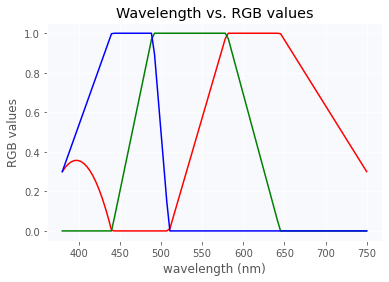

In [149]:
# ==================== 
# Physical Parameters  
# ====================
Ip = 4**2                 # peak intensity               
Ib = 1.0                  # background illumination                       
Lambda = 0.651e-6         # wavelength
k0 = 2*np.pi/Lambda       # vacuum wavevector                 
n0 = 1.                   # background index of refraction      
Lz = 5e-4                  # computational length of sample    
Lx = 1e-3                 # computational width of sample          

w0 = 0.25e-3              # beam width of gaussian beam parameter

h = 0.67e-3              # slit separation
inputposition=-0*1e-6    # input position 
inputposition=+h/2       # input position 

# =========================
# Computational Parameters 
# =========================
nstepx = 2000             # number of transverse grid points
nstepz = 500              # number of longitudinal propagation steps

deltax = Lx/nstepx        # resolution in the x direction
deltaz = Lz/nstepz        # resolution in the z direction, IMPORTANT
deltaf = 1/Lx             # spatial frequency step

# ===================
# Meshgrid generation
# ===================
z = cp.arange(0, Lz+deltaz, deltaz)                
x = -Lx/2 + (cp.arange(0, nstepx, 1))*deltax

# =====================
# Dispersive Step Setup
# =====================
# this is to get rid of fftshifts and the sort

ntx = 0     
kx = cp.zeros(nstepx)                              
for nn in range(nstepx):
    ikx = nn - ntx
    kx[nn]=2*np.pi*deltaf*ikx
    if nn + 1 - nstepx/2 == 0:
      ntx = nstepx
      
# =======================
# Input fields definition  
# =======================
def Gaussian(x, Ip = Ip, w0=w0):
  return cp.sqrt(Ip)*cp.exp(-(x**2)/(w0**2))

# ================
# Propagation loop
# ================
def propagate(Field, k = k0, nstepz=nstepz, deltaz=deltaz, keep_memory=False):
  # Fast fourier transform api
  fft, ifft = cp.fft.fft, cp.fft.ifft # faster with big matrices
  if keep_memory:
    FieldModuleMemory = cp.zeros(shape=(nstepx, nstepz+1))
    FieldModuleMemory[:, 0] = cp.abs(Field)
  else:
    FieldModuleMemory = None
  ArgumentOfPropagator  = ((k*n0)**(-1)*(kx**2))*(deltaz/2);             
  Propagator = cp.exp(1j*ArgumentOfPropagator)
  tstart = time()
  for hh in range(nstepz):
      
      FieldTransform = fft(Field)*Propagator
      Field = ifft(FieldTransform)

      if keep_memory:
        FieldModuleMemory[:, 1+hh] = cp.abs(Field)

  print(f'elapsed time:{time()-tstart}')
  return Field, FieldModuleMemory

# =================
# Plotting function
# =================
def plot(Power, figsize=(15, 15), width=40, unit="mm"):
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, extent=[-width,width,-width,width], vmin=0)
  return fig, ax

# =============================
# To convert wavelength to cmap
#==============================
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)

wavelengths = np.linspace(380, 750, 100) # in nanometers
rgbs = np.stack([wavelength_to_rgb(wl) for wl in wavelengths])
plt.plot(wavelengths, rgbs[:, 0], "r-")
plt.plot(wavelengths, rgbs[:, 1], "g-")
plt.plot(wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.show()

cmap = wavelength_to_cmap(Lambda*1e9) #light at the wavelength used in our experiment

# ======================
# To plot final spectrum
# ======================
def propagate_and_get_rgb(InputField, wavelength):
  k = 2*np.pi/(wavelength)
  OutputField, FieldModuleMemory = propagate(InputField, k, keep_memory=True)
  P = cp.abs(OutputField)**2
  if P.ndim == 1:
    P = cp.stack((cp.abs(OutputField)**2,)*100, axis=0)
  rgb = cp.stack((P,)*3, axis=-1)/cp.max(P)
  return rgb*wavelength_to_rgb(wavelength*1e9), OutputField, FieldModuleMemory

# ====================
# Show result function
# ====================
def show_results(OutputPower, FieldModuleMemory, Color):
  fig = plt.figure(constrained_layout=True, figsize=(20, 20))
  gs = fig.add_gridspec(3, 3)

  ax1 = fig.add_subplot(gs[0, :2])
  ax1.set_title('Output power spectrum')
  ax1.plot(OutputPower)
  ax2 = fig.add_subplot(gs[1, :2])
  ax2.set_title('Diffracted light')
  ax2.imshow(Color, extent=[-10, 10, -3, 3])
  ax2.grid(False)

  ax3 = fig.add_subplot(gs[:2, 2])
  ax3.set_title('Diffracted light')
  ax3.imshow(FieldModuleMemory.T, origin='lower', extent=[-4, 4, -7, 7])
  ax3.grid(False)

(-5e-05, 5e-05)

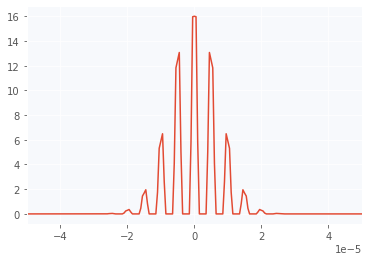

In [150]:
# =================
# Creating z=0 mask
# =================
InputField = 0*x          # Initializing field
dist = 5e-6               # distance betwen slices
width = 1e-6              # width of slices
N = 20                    # slice number

'''initializing field in z=0'''
InputField += np.sqrt(Ip)*(np.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  InputField += np.sqrt(Ip)*(np.exp(-(x-n*dist)**20/(width**20))+np.exp(-(x+n*dist)**20/(width**20)))
InputField *= Gaussian(x, w0=10e-6)
InputPower = cp.abs(InputField)**2
# visualizing the field in z=0
plt.plot(x, InputField)
plt.xlim((-5e-5, 5e-5))

In [151]:
# =====================
# Red light propagation
# =====================
Red, OutputField, FieldModuleMemory = propagate_and_get_rgb(InputField, Lambda)
OutputPower = cp.abs(OutputField)**2

elapsed time:0.06679296493530273


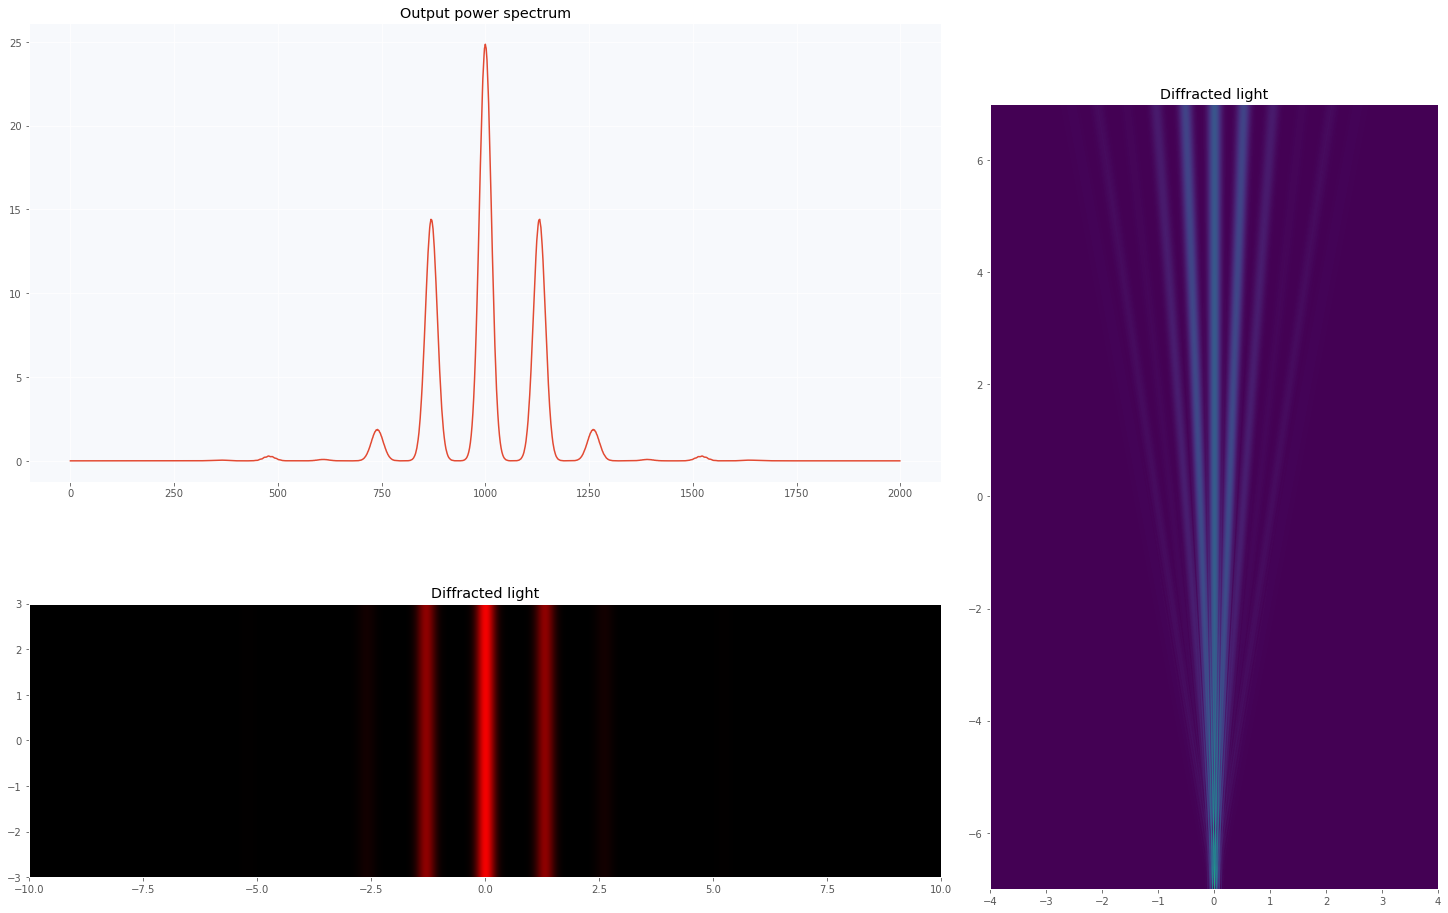

In [152]:
show_results(OutputPower, FieldModuleMemory, Red)

In [156]:
# =======================
# White light propagation
# =======================
''' making color array '''
wavelengths = cp.linspace(400, 750, 7)*1e-9
Color, OutputField, FieldModuleMemory = propagate_and_get_rgb(InputField, 500)
for wavelength in wavelengths:
  Color_t, OutputField_t, FieldModuleMemory_t = propagate_and_get_rgb(InputField, wavelength)
  Color += Color_t
  OutputField += OutputField_t
  FieldModuleMemory += FieldModuleMemory_t

elapsed time:0.06900358200073242
elapsed time:0.06666278839111328
elapsed time:0.062340497970581055
elapsed time:0.06894063949584961
elapsed time:0.062150001525878906
elapsed time:0.06927227973937988
elapsed time:0.06739163398742676
elapsed time:0.060381412506103516
elapsed time:0.0673975944519043
elapsed time:0.06897616386413574
elapsed time:0.06360363960266113
elapsed time:0.06479310989379883
elapsed time:0.06339383125305176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


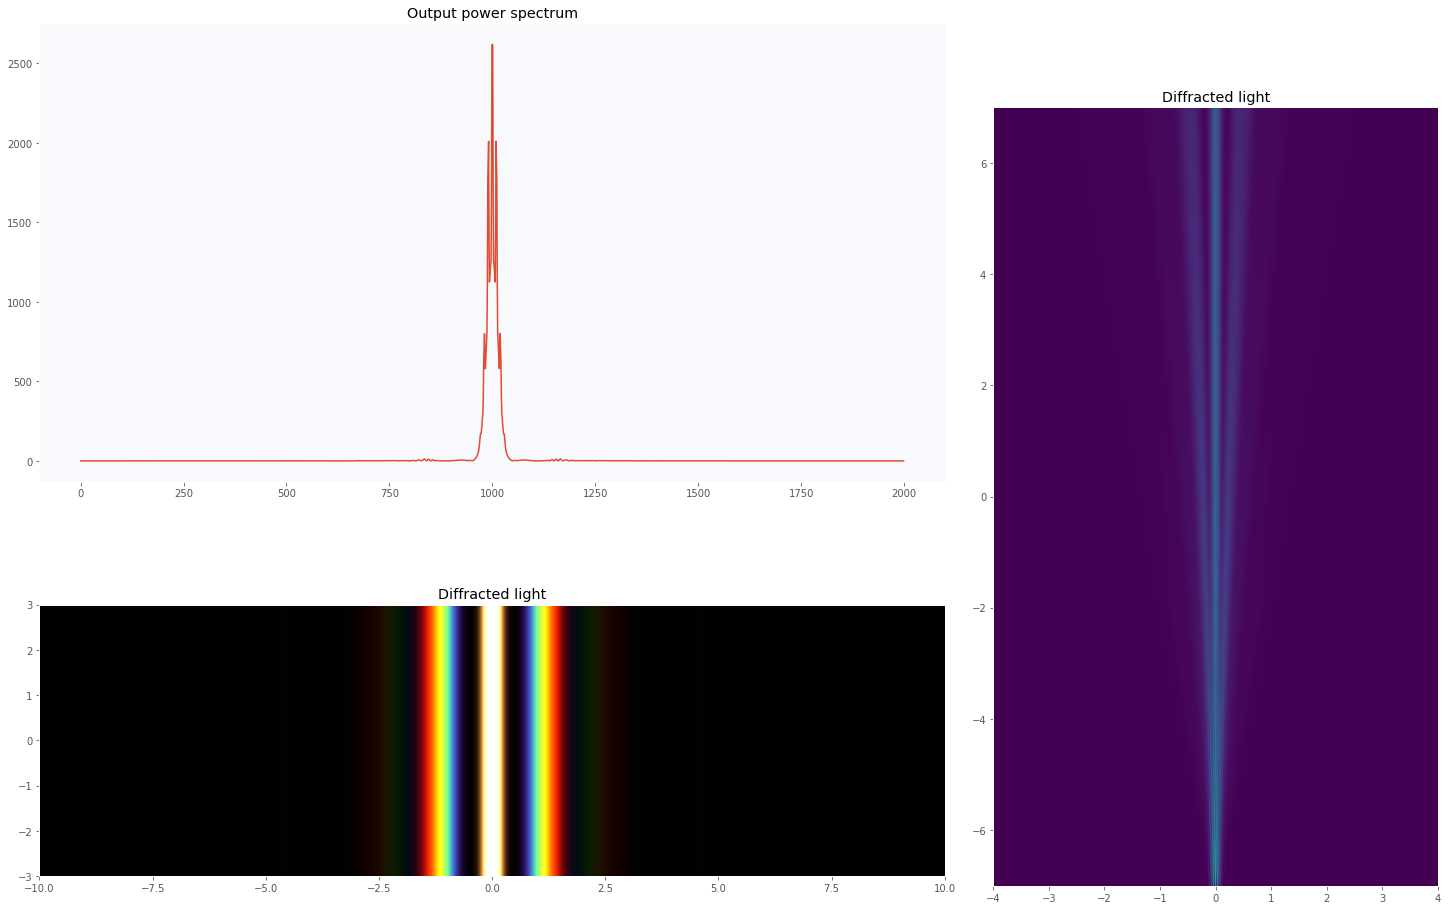

In [157]:
show_results(cp.abs(OutputField)**2, FieldModuleMemory, Color)